# LR Models for Study 3

In [1]:
from matplotlib import pyplot 
from numpy import mean
from numpy import std
from sklearn.calibration import CalibratedClassifierCV as CCCV
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score as ppv
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score as recall
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import itertools
import joblib
import numpy as np
import pandas as pd
import pip
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#Hyperparameter grid
space=dict()
space['solver']=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
space['penalty']=['none', 'l1', 'l2', 'elasticnet']
space['C']=[100, 10, 1, 0.1, 0.01]

clf=LogisticRegression(random_state=26, n_jobs=-1)
searchLR=RandomizedSearchCV(clf, space, scoring='roc_auc', random_state=26, n_jobs=-1, n_iter=100, refit=True)

### Suicidal ideation Models

In [5]:
Xi=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\Xi.csv')
Xi_hold=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\Xi_hold.csv')
y=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_si.csv')
y_hold_si=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_si.csv')

In [6]:
Xi.shape
Xi_hold.shape
y.shape
y_hold_si.shape

(1699, 1011)

(729, 1012)

(1699, 1)

(729, 1)

In [7]:
#Getting rid of unnamed column- this often occurs after csv is read with the index from excel
Xi_hold= Xi_hold.drop('Unnamed: 0', axis=1)

In [8]:
#Some fits will fail due to solver-penalty incompatibility
searchLR.fit(Xi, y)
searchLR.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\

RandomizedSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=26),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=26, scoring='roc_auc')

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}

In [9]:
cLR=CCCV(searchLR.best_estimator_, method='isotonic')
cLR.fit(Xi, y)
joblib.dump(searchLR.best_estimator_, 'LR_si_Uncalibrated.sav')
joblib.dump(cLR, 'LR_si.sav')

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\u

CalibratedClassifierCV(estimator=LogisticRegression(C=0.1, n_jobs=-1,
                                                    penalty='l1',
                                                    random_state=26,
                                                    solver='liblinear'),
                       method='isotonic')

['LR_si_Uncalibrated.sav']

['LR_si.sav']

In [10]:
#Creating function that predicts probabilities using the calibrated model
def predict(data):
    proba=cLR.predict_proba(data)
    proba=proba[:, 1]
    print('Probs: %.3f (%.3f)' % (mean(proba), std(proba)) )

    return proba

In [11]:
si_trainprob=predict(Xi)
si_testprob=predict(Xi_hold)


Probs: 0.131 (0.117)
Probs: 0.123 (0.107)


In [12]:
#Creating a function which evaluates the model
def eval(y_hold, proba, thresh):
    ypred=np.where(proba>thresh, 1, 0)
    f1= f1_score(y_hold, ypred)
    print(f'F1= {f1:f}')
    sens= recall(y_hold, ypred)
    print(f'Sensitivity= {sens:f}')
    tn, fp, fn, tp= confusion(y_hold, ypred).ravel()
    spec=tn/(tn+fp)
    print(f'Specificity= {spec:f}')
    auc= roc_auc_score(y_hold, proba)
    print(f'AUROC= {auc:f}')

    return ypred, f1, sens, spec, auc

In [13]:
ypred, f1, sens, spec, auc=eval(y_hold_si, si_testprob, 0.188868)

F1= 0.380165
Sensitivity= 0.479167
Specificity= 0.842022
AUROC= 0.741830


In [14]:
#Plotting function
def graphs(y_hold, testprob):
#ROC curve
    fpr, tpr, thresholds=roc_curve(y_hold, testprob)
    # plot the roc curve for the model 
    pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
    pyplot.plot(fpr, tpr, marker='.', label='LR')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()
#Calibration curve
    # reliability diagram
    fop, mpv = calibration_curve(y_hold, testprob, n_bins=10)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.xlabel('Predicted probability')
    pyplot.ylabel('True probability')
    pyplot.plot(mpv, fop, marker='.')
    pyplot.show()
#Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_hold, si_testprob)
    # plot the roc curve for the model
    y_hold=np.ravel(y_hold)
    no_skill = len(y_hold[y_hold==1]) / len(y_hold)
    pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    # show the plot
    pyplot.show()

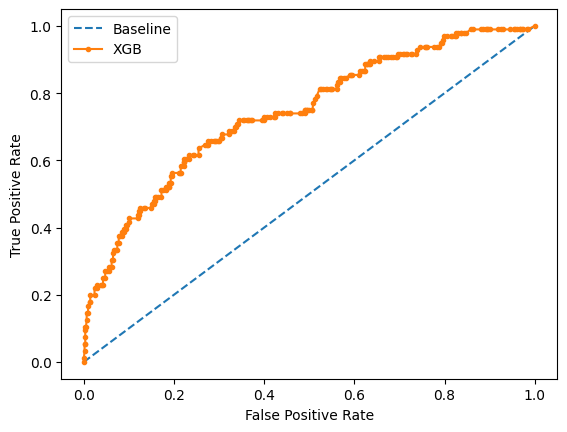

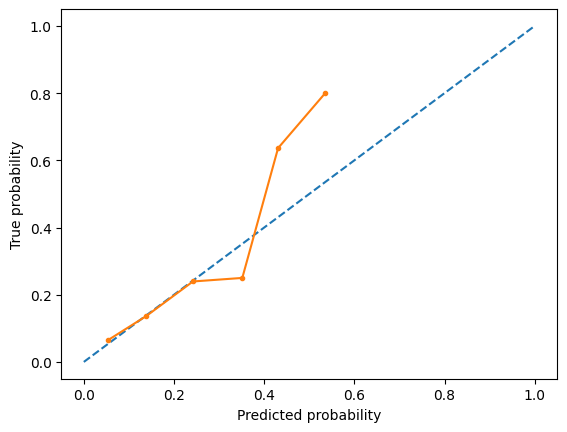

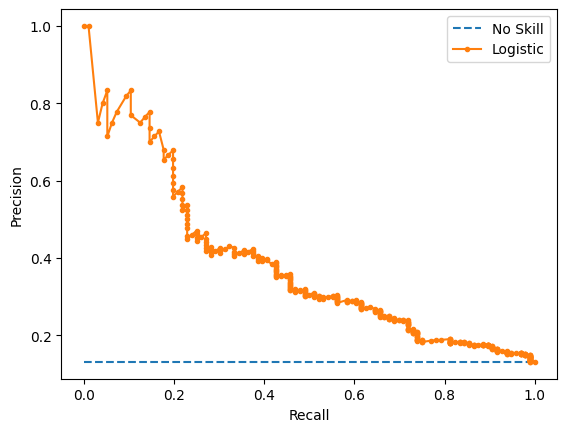

In [15]:
graphs(y_hold_si, si_testprob)

# Self-harm Models

In [16]:
y=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_nssi.csv')
y_hold=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_nssi.csv')

In [17]:
np.average(y_hold)

0.07681755829903979

In [18]:
Xi.shape
Xi_hold.shape
y.shape
y_hold_si.shape

(1699, 1011)

(729, 1011)

(1699, 1)

(729, 1)

In [19]:
searchLR.fit(Xi, y)
searchLR.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\

RandomizedSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=26),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=26, scoring='roc_auc')

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}

In [20]:
cLR=CCCV(searchLR.best_estimator_, method='isotonic')
cLR.fit(Xi, y)
joblib.dump(searchLR.best_estimator_, 'LR_nssi_Uncalibrated.sav')
joblib.dump(cLR, 'LR_nssi.sav')

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\u

CalibratedClassifierCV(estimator=LogisticRegression(C=0.1, n_jobs=-1,
                                                    penalty='l1',
                                                    random_state=26,
                                                    solver='liblinear'),
                       method='isotonic')

['LR_nssi_Uncalibrated.sav']

['LR_nssi.sav']

In [21]:
cLR=joblib.load('LR_nssi.sav')
nssi_trainprob=predict(Xi)
nssi_testprob=predict(Xi_hold)


Probs: 0.077 (0.080)
Probs: 0.075 (0.082)


In [22]:
ypred, f1, sens, spec, auc=eval(y_hold, nssi_testprob, 0.138621)

F1= 0.308642
Sensitivity= 0.446429
Specificity= 0.879643
AUROC= 0.727645


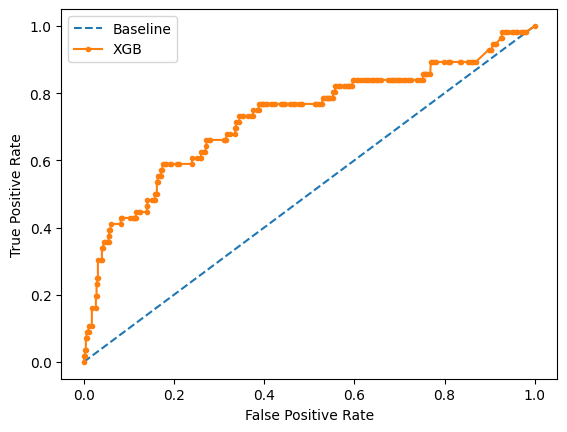

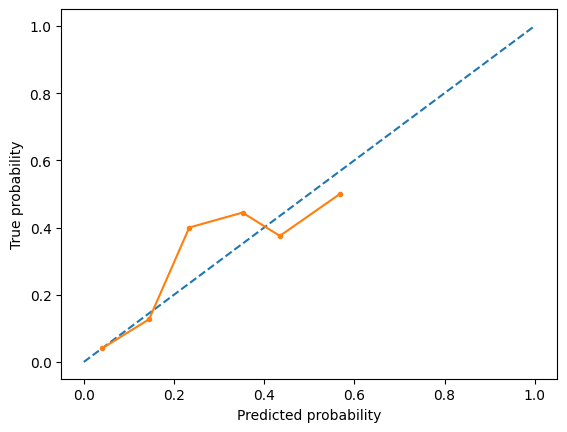

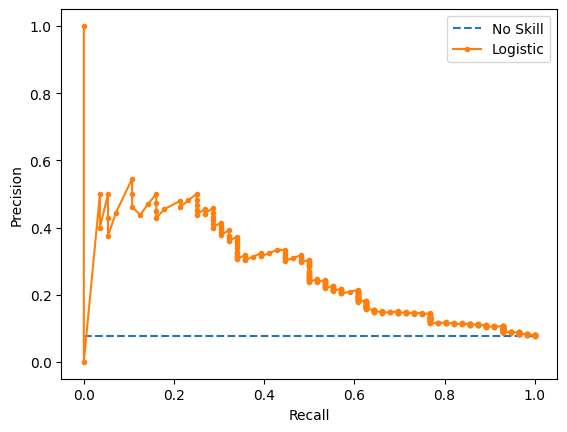

In [23]:
graphs(y_hold, nssi_testprob)

# Attempt Models

In [24]:
y=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_att.csv')
y_hold=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_att.csv')

In [25]:
np.average(y)

0.0429664508534432

In [26]:
Xi.shape
Xi_hold.shape
y.shape
y_hold_si.shape

(1699, 1011)

(729, 1011)

(1699, 1)

(729, 1)

In [27]:
searchLR.fit(Xi, y)
searchLR.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\

RandomizedSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=26),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=26, scoring='roc_auc')

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}

In [28]:
cLR=CCCV(searchLR.best_estimator_, method='isotonic')
cLR.fit(Xi, y)
joblib.dump(searchLR.best_estimator_, 'LR_att_Uncalibrated.sav')
joblib.dump(cLR, 'LR_att.sav')

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\u

CalibratedClassifierCV(estimator=LogisticRegression(C=0.01, n_jobs=-1,
                                                    random_state=26,
                                                    solver='liblinear'),
                       method='isotonic')

['LR_att_Uncalibrated.sav']

['LR_att.sav']

In [29]:
att_trainprob=predict(Xi)
att_testprob=predict(Xi_hold)


Probs: 0.044 (0.047)
Probs: 0.045 (0.048)


In [30]:
ypred, f1, sens, spec, auc=eval(y_hold, att_testprob, 0.074037)

F1= 0.191083
Sensitivity= 0.468750
Specificity= 0.842181
AUROC= 0.766992


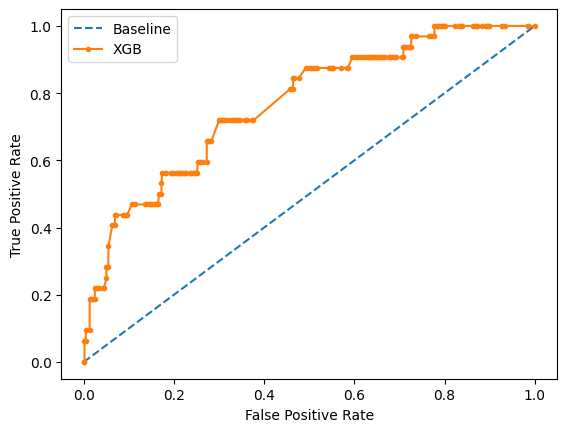

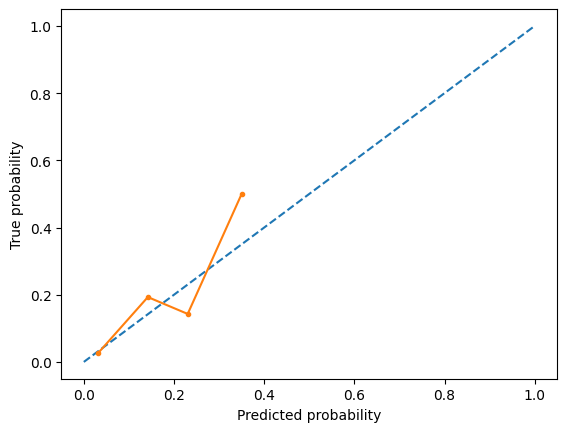

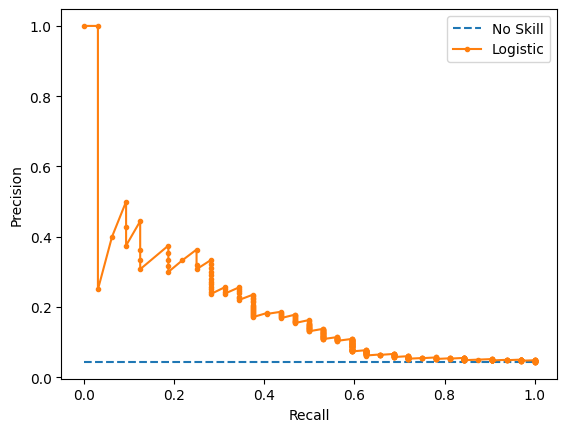

In [31]:
graphs(y_hold, att_testprob)

# SITBs Models

In [32]:
y=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_sitbs.csv')
y_hold=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_sitbs.csv')

In [33]:
np.average(y_hold)

0.16598079561042525

In [34]:
Xi.shape
Xi_hold.shape
y.shape
y_hold_si.shape

(1699, 1011)

(729, 1011)

(1699, 1)

(729, 1)

In [35]:
searchLR.fit(Xi, y)
searchLR.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\

RandomizedSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=26),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=26, scoring='roc_auc')

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}

In [36]:
cLR=CCCV(searchLR.best_estimator_, method='isotonic')
cLR.fit(Xi, y)
joblib.dump(searchLR.best_estimator_, 'LR_sitbs_Uncalibrated.sav')
joblib.dump(cLR, 'LR_sitbs.sav')

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\.venv\lib\site-packages\sklearn\u

CalibratedClassifierCV(estimator=LogisticRegression(C=0.1, n_jobs=-1,
                                                    penalty='l1',
                                                    random_state=26,
                                                    solver='liblinear'),
                       method='isotonic')

['LR_sitbs_Uncalibrated.sav']

['LR_sitbs.sav']

In [37]:
sitbs_trainprob=predict(Xi)
sitbs_testprob=predict(Xi_hold)

Probs: 0.165 (0.130)
Probs: 0.161 (0.125)


In [38]:
ypred, f1, sens, spec, auc=eval(y_hold, sitbs_testprob, 0.208806)

F1= 0.422360
Sensitivity= 0.561983
Specificity= 0.781250
AUROC= 0.710465


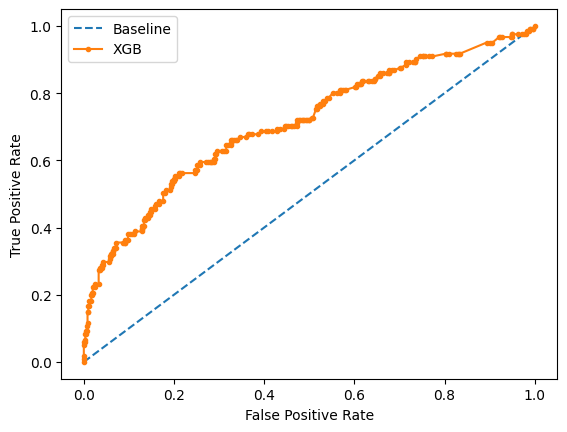

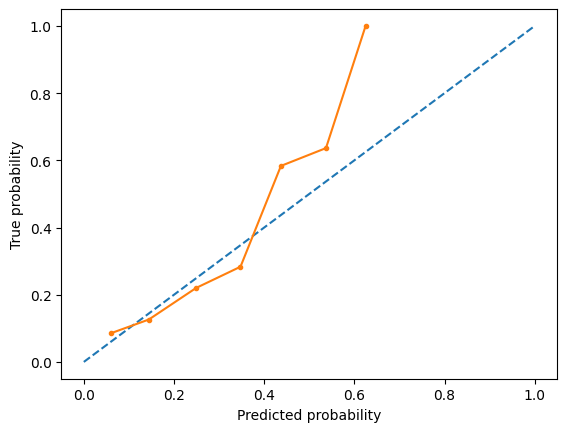

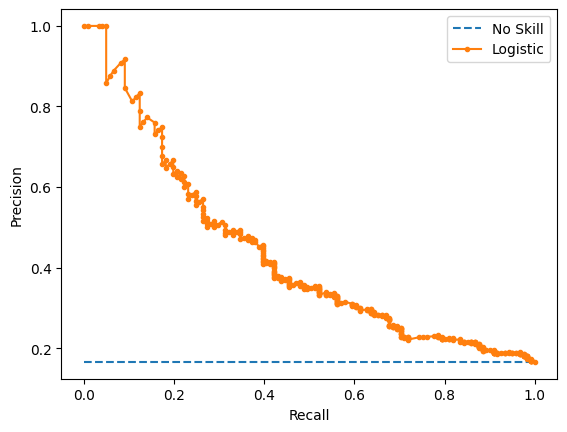

In [39]:
graphs(y_hold, sitbs_testprob)

Graphs

In [40]:
y_hold_si=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_si.csv')
y_hold_nssi=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_nssi.csv')
y_hold_att=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_att.csv')
y_hold_sitbs=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y_hold_sitbs.csv')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

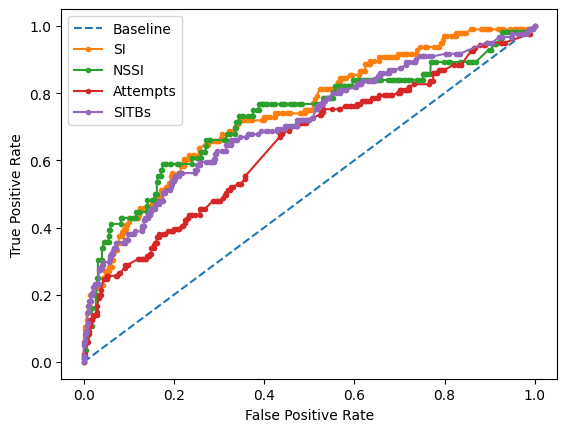

In [41]:
#ROC curve
fpr1, tpr1, thresholds1=roc_curve(y_hold_si, si_testprob)
fpr2, tpr2, thresholds2=roc_curve(y_hold_nssi, nssi_testprob)
fpr3, tpr3, thresholds3=roc_curve(y_hold, att_testprob)
fpr4, tpr4, thresholds4=roc_curve(y_hold, sitbs_testprob)
# plot the roc curve for the model 
pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
pyplot.plot(fpr1, tpr1, marker='.', label='SI')
pyplot.plot(fpr2, tpr2, marker='.', label='NSSI')
pyplot.plot(fpr3, tpr3, marker='.', label='Attempts')
pyplot.plot(fpr4, tpr4, marker='.', label='SITBs')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Text(0.5, 0, 'Predicted probability')

Text(0, 0.5, 'True probability')

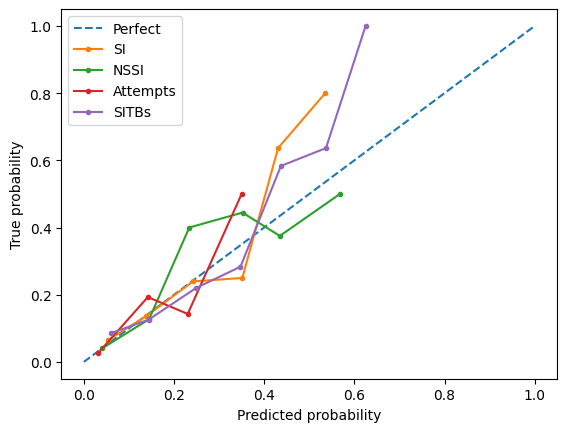

In [42]:
#Calibration curve
# reliability diagram
fop1, mpv1 = calibration_curve(y_hold_si, si_testprob, n_bins=10)
fop2, mpv2 = calibration_curve(y_hold_nssi, nssi_testprob, n_bins=10)
fop3, mpv3 = calibration_curve(y_hold_att, att_testprob, n_bins=10)
fop4, mpv4 = calibration_curve(y_hold_sitbs, sitbs_testprob, n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--', label='Perfect')
#plot model reliability
pyplot.plot(mpv1, fop1, marker='.', label='SI')
pyplot.plot(mpv2, fop2, marker='.', label='NSSI')
pyplot.plot(mpv3, fop3,  marker='.', label='Attempts')
pyplot.plot(mpv4, fop4, marker='.', label='SITBs')
# plot model reliability
pyplot.xlabel('Predicted probability')
pyplot.ylabel('True probability')
pyplot.legend()
pyplot.show()


Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

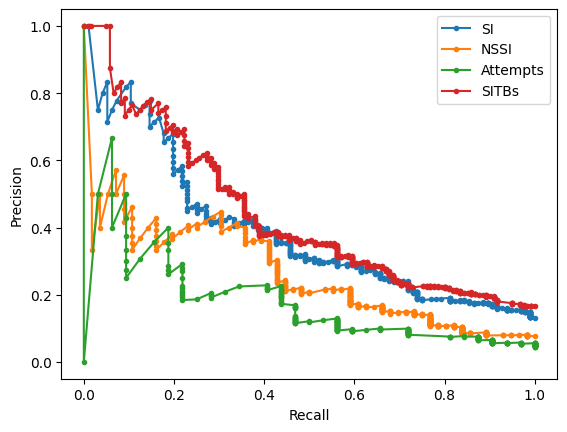

In [43]:
# calculate pr-curve
precision1, recall1, thresholds1 = precision_recall_curve(y_hold_si, si_testprob)
precision2, recall2, thresholds2 = precision_recall_curve(y_hold_nssi, nssi_testprob)
precision3, recall3, thresholds3 = precision_recall_curve(y_hold_att, att_testprob)
precision4, recall4, thresholds4 = precision_recall_curve(y_hold_sitbs, sitbs_testprob)
# plot the roc curve for the model
pyplot.plot(recall1, precision1, marker='.', label='SI')
pyplot.plot(recall2, precision2, marker='.', label='NSSI')
pyplot.plot(recall3, precision3, marker='.', label='Attempts')
pyplot.plot(recall4, precision4, marker='.', label='SITBs')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()